# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


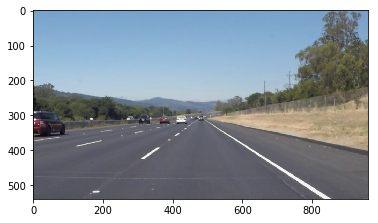

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image); # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [35]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    ##return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def calculate_vertices(imshape):
    vertices = np.array([[(0,imshape[0]),(int(2*imshape[1]/5), int(3*imshape[0]/5)), (int(3*imshape[1]/5), int(3*imshape[0]/5)), (imshape[1], imshape[0])]], dtype=np.int32)
    return vertices

def draw_lines(img, lines, color=[0, 255, 0], thickness=5, frame_height=0, frame_width=0):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, frame_height=img.shape[0], frame_width=img.shape[1])
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Otsu thresholding automatically selects an appropriate threshold based on the color value distribution

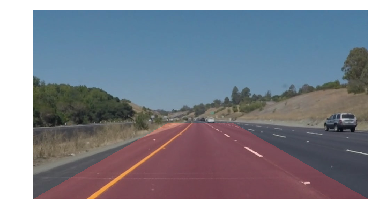

In [37]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
vertices = calculate_vertices(image.shape)
#defining a blank mask to start with
mask = np.zeros_like(image) 
masked_region=cv2.fillPoly(mask,vertices,(255,0,0))

fig,ax=plt.subplots()
ax.imshow(image)
ax.imshow(masked_region,alpha=0.2, cmap="RdBu")
ax.axis('off')
plt.show()

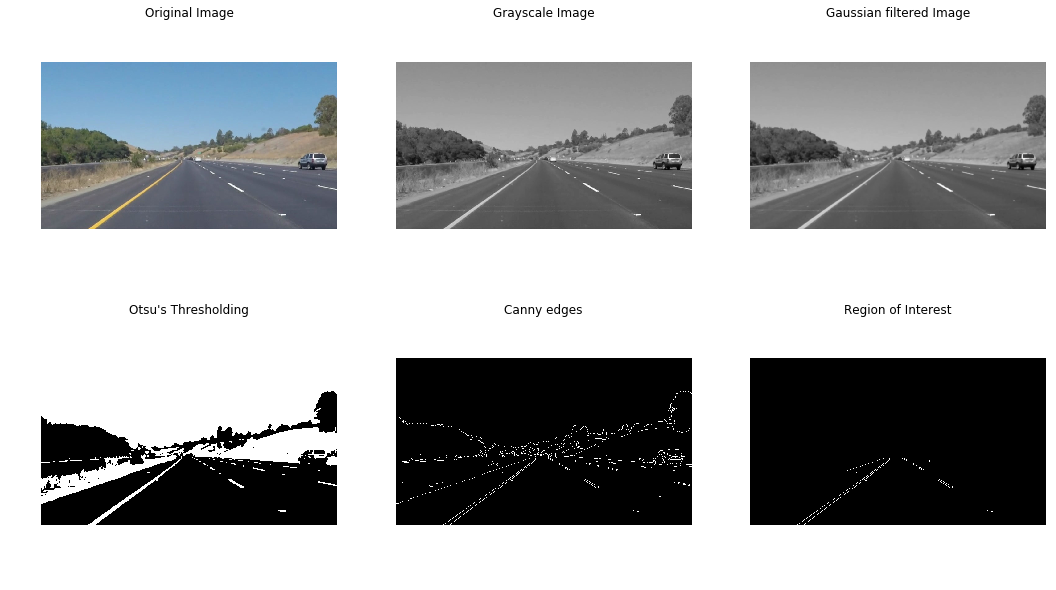

The Otsu threshold of this image is 126.0


In [5]:
image_gr = grayscale(image)
image_gr_blur = gaussian_blur(image_gr, 5)
ret,th = cv2.threshold(image_gr_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
vertices = calculate_vertices(image.shape)
image_canny = canny(image_gr_blur, 65, 130)
image_region =  region_of_interest(image_canny, vertices)


# plot all the images and their histograms
images = [image, image_gr, image_gr_blur, th, image_canny, image_region]
titles = ["Original Image", "Grayscale Image", "Gaussian filtered Image","Otsu's Thresholding", "Canny edges", "Region of Interest"]

fig, ax = plt.subplots(2,3, sharex='col',figsize=(18, 10))
ax[0][0].imshow(images[0])
ax[0][0].set_title(titles[0])
ax[0][0].axis('off')
ax[0][1].imshow(images[1],'gray')
ax[0][1].set_title(titles[1])
ax[0][1].axis('off')
ax[0][2].imshow(images[2],'gray')
ax[0][2].set_title(titles[2])
ax[0][2].axis('off')
ax[1][0].imshow(images[3],'gray')
ax[1][0].set_title(titles[3])
ax[1][0].axis('off')
ax[1][1].imshow(images[4],'gray')
ax[1][1].set_title(titles[4])
ax[1][1].axis('off')
ax[1][2].imshow(images[5],'gray')
ax[1][2].set_title(titles[5])
ax[1][2].axis('off')
plt.show()

print('The Otsu threshold of this image is', ret)

We will use this value as the basis for our Canny Thresholds. The lane finder pipeline converts the image to grayscale, applies a blur filter, singles out edges with the Canny algorithm and finally detects lines using the Hough transform. We will try to detect edges with a length of at least 40 pixels with a maximal gap of 20 pixels

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# parameters for the filtering algorithms
blur_kernel_size = 5
canny_low_threshold = 65
canny_high_threshold = 130
hough_rho = 2
hough_theta = np.pi/180
hough_threshold = 40
hough_min_line_len = 40
hough_max_line_gap = 20

def lane_finder(image):
    imshape = image.shape
    vertices = calculate_vertices(imshape)
    image_gr = grayscale(image)
    image_gr_blur = gaussian_blur(image_gr, blur_kernel_size)
    image_canny = canny(image_gr_blur, canny_low_threshold, canny_high_threshold)
    image_masked_edges = region_of_interest(image_canny, vertices)
    image_lines = hough_lines(image_masked_edges, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)
    return image_lines


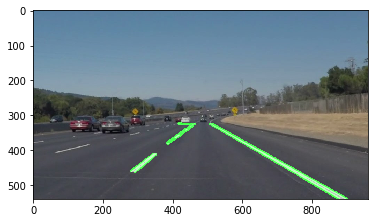

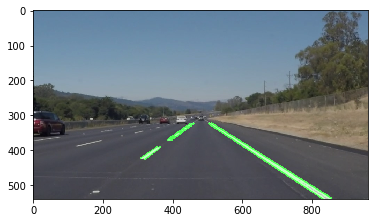

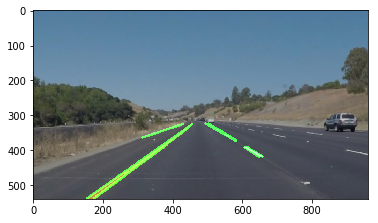

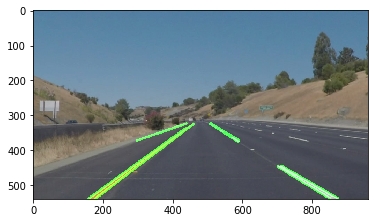

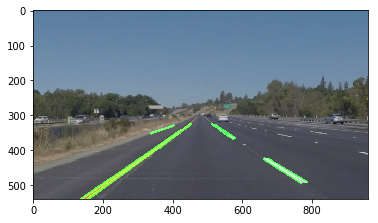

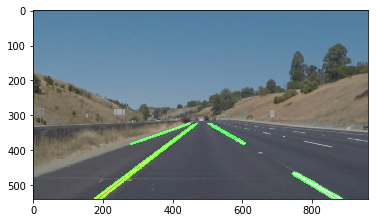

In [7]:
dir = "test_images/"
for img in os.listdir(dir):
    image = mpimg.imread(dir+img)
    image_lanes = lane_finder(image)
    result = weighted_img(image_lanes, image)
    plt.figure()
    plt.imshow(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_lanes = lane_finder(image)
    result = weighted_img(image_lanes, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.close()

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 10 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

<video width="640" height="360" controls src="test_videos_output/solidWhiteRight.mp4" />

As we can see, the lane markings in the region of interest are clearly detected. However, we are still picking up a few additional lines from cars inside the region of interest. We could now fine tune the parameters to get ride of unwanted detections or we could apply additional filters to the detected lines (like filtering by slope, statistical filters, color filters). I chose the latter approach since it is probably more reliable in other contexts.

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
def compute_intersection(params,frame_height):
    x_intersect = np.tan(params[0])*frame_height + params[1]
    return (params[0],params[1],x_intersect)

def compute_params(line):
    """
    Calculate angle theta between x and y axis, and intersection with the lower border
    of the image:
    x=tan(theta)*y+b
    """
    for x1,y1,x2,y2 in line:
        theta = np.arctan((x2-x1)/(y2-y1))
        b = x1-(x2-x1)/(y2-y1)*y1
    return (theta, b)

def compute_avg_line(filtered_lines):
    y_min = 0.0
    line_params = [0.0,0.0,0.0]
    total_length = 0.0
    for line in filtered_lines:
        for x1,y1,x2,y2 in line[0]:
            length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
            line_add=[length * x for x in line[1]]
            line_params=np.add(line_params,line_add)
            total_length+=length
    if total_length > 0.0:
        y_min = min([line[0][0][1] for line in filtered_lines]+[line[0][0][3] for line in filtered_lines])
        line_params=line_params/total_length
    return line_params,y_min,total_length
    

def draw_lines(img, lines, color=[0, 255, 0], thickness=5, frame_height=0, frame_width=0):
    """
    This definition overwrites  the previous (simpler) definition of the draw_lines function.
    Inputs are an empty image of the correct dimensions and lines obtained by the probabilistic
    Hough transform.
    
    We first filter the lines by discarding all lines that do not intersect the lower border 
    of the image. All lines that intersect left of the midpoint belong to the left lane marking,
    all others to the right markings.
    """
    lines_with_parameters = [(line, compute_intersection(compute_params(line),frame_height)) for line in lines]
    filtered_lines_left = [line for line in lines_with_parameters if 0.0 > line[1][0] and 0 < line[1][2] < frame_width/2]
    filtered_lines_right = [line for line in lines_with_parameters if 0.0 < line[1][0] and frame_width/2 <= line[1][2] < frame_width]
    
    left_line_params,left_y_min,total_length_left = compute_avg_line(filtered_lines_left)
    if total_length_left>0.0:
        cv2.line(img, (int(left_line_params[2]), frame_height), (int(np.tan(left_line_params[0])*left_y_min + left_line_params[1]), left_y_min), color, thickness)
    # else:
    #    print("No left lane found")
    
    right_line_params,right_y_min,total_length_right = compute_avg_line(filtered_lines_right)
    if total_length_right>0.0:
        cv2.line(img, (int(right_line_params[2]), frame_height), (int(np.tan(right_line_params[0])*right_y_min + right_line_params[1]), right_y_min), color, thickness)
    # else:
    #    print("No right lane found")

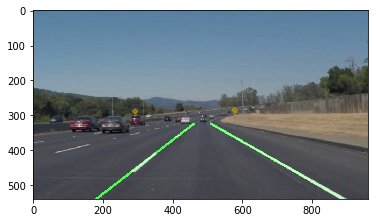

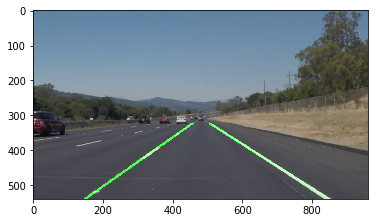

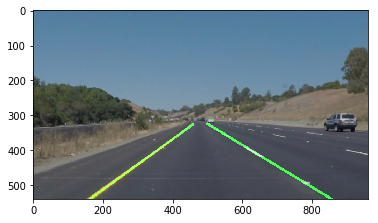

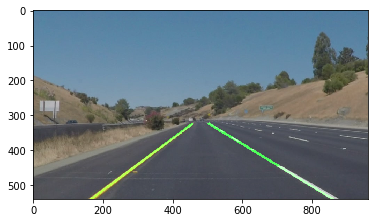

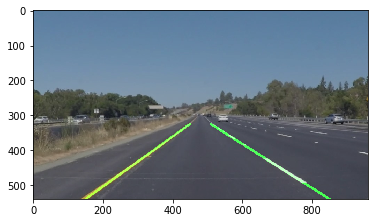

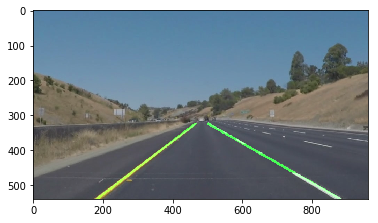

In [12]:
dir = "test_images/"
for img in os.listdir(dir):
    image = mpimg.imread(dir+img)
    image_lanes = lane_finder(image)
    result = weighted_img(image_lanes, image)
    plt.figure()
    plt.imshow(result)

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip2.reader.close()
clip2.close()

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 29.2 s


<video width="640" height="360" controls src="test_videos_output/solidYellowLeft.mp4" />

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Since the video was recorded with different settings and in a different car, we should probabily first re-calibrate the parameters

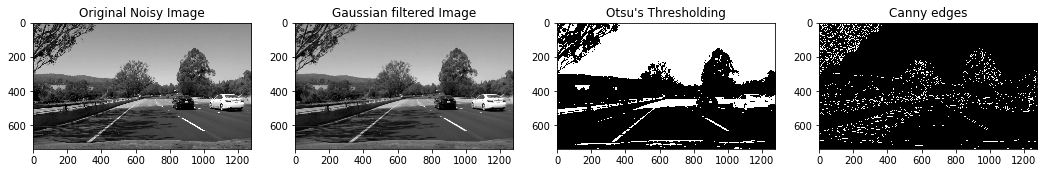

The Otsu threshold of this image is 113.0


In [14]:
image = mpimg.imread('challenge/shadow2.jpg')
image_gr = grayscale(image)
image_gr_blur = gaussian_blur(image_gr, 5)
ret,th = cv2.threshold(image_gr_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
edges = cv2.Canny(image_gr_blur,66,113)

# plot all the images and their histograms
images = [image_gr, image_gr_blur, th, edges]
titles = ["Original Noisy Image","Gaussian filtered Image","Otsu's Thresholding", "Canny edges"]

fig, ax = plt.subplots(1,4,figsize=(18, 10))
ax[0].imshow(images[0],'gray')
ax[0].set_title(titles[0])
ax[1].imshow(images[1],'gray')
ax[1].set_title(titles[1])
ax[2].imshow(images[2],'gray')
ax[2].set_title(titles[2])
ax[3].imshow(images[3],'gray')
ax[3].set_title(titles[3])
plt.show()

print('The Otsu threshold of this image is', ret)

In [15]:
blur_kernel_size = 5
canny_low_threshold = 66
canny_high_threshold = 113
hough_rho = 3
hough_theta = np.pi/180
hough_threshold = 40
hough_min_line_len = 40
hough_max_line_gap = 10

def calculate_vertices(imshape):
    vertices = np.array([[(0,665),(int(2*imshape[1]/5), int(3*imshape[0]/5)), (int(3*imshape[1]/5), int(3*imshape[0]/5)), (imshape[1], 665)]], dtype=np.int32)
    return vertices
    

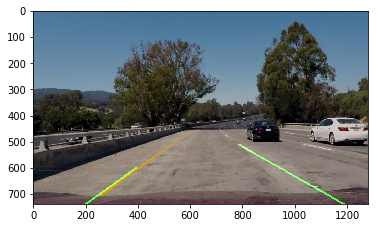

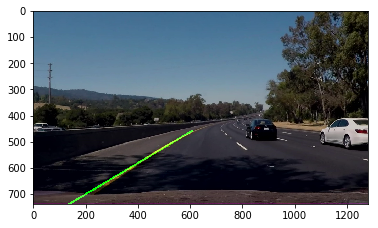

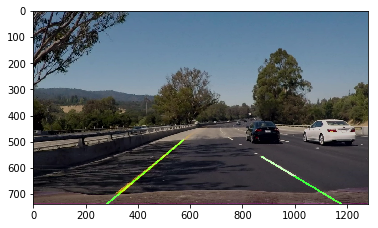

In [16]:
dir = "challenge/"
for img in os.listdir(dir):
    image = mpimg.imread(dir+img)
    image_lanes = lane_finder(image)
    result = weighted_img(image_lanes, image)
    plt.figure()
    plt.imshow(result)

In [17]:
challenge_output = 'test_videos_output/challenge_1.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
clip3.reader.close()
clip3.close()

Moviepy - Building video test_videos_output/challenge_1.mp4.
Moviepy - Writing video test_videos_output/challenge_1.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_1.mp4
Wall time: 21.5 s


<video width="640" height="360" controls src="test_videos_output/challenge_1.mp4" />

In [18]:
# new lines are added to the cumulative average with this ratio
avg_ratio = 0.2

# moving average for the left lane markings
avg_left_line_params = [0.0,0.0,0.0]
error_frames_left = 0
contributing_frames_left = 0

# moving average for the right lane markings
avg_right_line_params = [0.0,0.0,0.0]
error_frames_right = 0
contributing_frames_right = 0

# after this number of frames without new lines, a new line is calculated
frame_threshold = 60

def initialize_avg_lines():
    global avg_left_line_params
    global error_frames_left
    global avg_right_line_params
    global error_frames_right
    avg_left_line_params = [0.0,0.0,0.0]
    error_frames_left = frame_threshold
    avg_right_line_params = [0.0,0.0,0.0]
    error_frames_right = frame_threshold

def draw_lines(img, lines, color=[0, 255, 0], thickness=5, frame_height=0, frame_width=0):
    """
    This definition overwrites  the previous (simpler) definition of the draw_lines function.
    Inputs are an empty image of the correct dimensions and lines obtained by the probabilistic
    Hough transform.
    
    We first filter the lines by discarding all lines that do not intersect the lower border 
    of the image. All lines that intersect left of the midpoint belong to the left lane marking,
    all others to the right markings.
    """
    lines_with_parameters = [(line, compute_intersection(compute_params(line),frame_height)) for line in lines]
    filtered_lines_left = [line for line in lines_with_parameters if -np.pi/8 > line[1][0] and 0 < line[1][2] < frame_width/2]
    filtered_lines_right = [line for line in lines_with_parameters if np.pi/8 < line[1][0] and frame_width/2 <= line[1][2] < frame_width]
    
    global avg_left_line_params
    global error_frames_left
    global contributing_frames_left
    global avg_right_line_params
    global error_frames_right
    global contributing_frames_right
    
    total_left_length = 0.0
    left_line_params = [0.0,0.0,0.0]
    for line in filtered_lines_left:
        for x1,y1,x2,y2 in line[0]:
            length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
            line_add=[length * x for x in line[1]]
            left_line_params=np.add(left_line_params,line_add)
            total_left_length+=length
    if total_left_length > 0.0:
        ## average over all lines on the left hand side if lines were found
        left_line_params=left_line_params/total_left_length
        ## only consider lines which are not too far from the moving average
        if np.abs(left_line_params[0]-avg_left_line_params[0])<np.pi/18.0 and np.abs(left_line_params[1]-avg_left_line_params[1])<50.0: 
            contributing_frames_left+=1
            error_frames_left=0
            avg_left_line_params=np.add(avg_ratio*left_line_params,(1.0-avg_ratio)*avg_left_line_params)
        else:
            error_frames_left+=1
            contributing_frames_left-=1
            if error_frames_left>=frame_threshold or contributing_frames_left<1:
            #    print("lane reset")
                avg_left_line_params = left_line_params
                error_frames_left = 0
                contributing_frames_left = 1
        if contributing_frames_left>frame_threshold/2 and error_frames_left <1:
            color=[0, 255, 0]
        else:
            color=[255, 165, 0]
    else:
        error_frames_left+=1
        contributing_frames_left-=1
        color=[255, 0, 0]
    cv2.line(img, (int(avg_left_line_params[2]), frame_height), (int(np.tan(avg_left_line_params[0])*3*frame_height/5 + avg_left_line_params[1]),int(3*frame_height/5)), color, thickness) 

    total_right_length = 0.0
    right_line_params = [0.0,0.0,0.0]
    for line in filtered_lines_right:
        for x1,y1,x2,y2 in line[0]:
            length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
            line_add=[length * x for x in line[1]]
            right_line_params=np.add(right_line_params,line_add)
            total_right_length+=length
    if total_right_length > 0.0:
        ## average over all lines on the right hand side if lines were found
        right_line_params=right_line_params/total_right_length
        ## only consider lines which are not too far from the moving average
        if np.abs(right_line_params[0]-avg_right_line_params[0])<np.pi/18.0 and np.abs(right_line_params[1]-avg_right_line_params[1])<50.0: 
            contributing_frames_right+=1
            error_frames_right=0
            avg_right_line_params=np.add(avg_ratio*right_line_params,(1.0-avg_ratio)*avg_right_line_params)
        else:
            error_frames_right+=1
            contributing_frames_right-=1
            if error_frames_right>=frame_threshold or contributing_frames_right<1:
            #    print("lane reset")
                avg_right_line_params = right_line_params
                error_frames_right = 0
                contributing_frames_right = 1
        if contributing_frames_right>frame_threshold/2 and error_frames_right <1:
            color=[0, 255, 0]
        else:
            color=[255, 165, 0]
    else:
        error_frames_right+=1
        contributing_frames_right-=1
        color=[255, 0, 0]
    cv2.line(img, (int(avg_right_line_params[2]), frame_height), (int(np.tan(avg_right_line_params[0])*3*frame_height/5 + avg_right_line_params[1]),int(3*frame_height/5)), color, thickness) 


In [19]:
challenge_output_2 = 'test_videos_output/challenge_2.mp4'

avg_ratio=0.3
frame_threshold = 10
initialize_avg_lines()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip4 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip4.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output_2, audio=False)
clip4.reader.close()
clip4.close()

Moviepy - Building video test_videos_output/challenge_2.mp4.
Moviepy - Writing video test_videos_output/challenge_2.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_2.mp4
Wall time: 21.6 s


<video width="640" height="360" controls src="test_videos_output/challenge_2.mp4" />

As we can see, our pipeline still has significant problem tracking the yellow line, while the white lane markings are relatively well detected. In the following we will implement a very rudimentary color filter for white and yellow, and apply it to the challenge trace: 

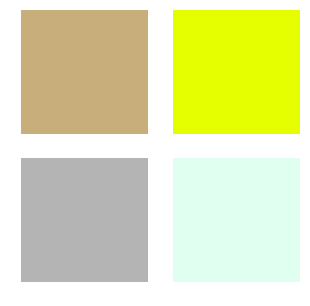

In [20]:
#### from matplotlib.colors import hsv_to_rgb
light_yellow = (20, 100, 200)
dark_yellow = (33,255,255)
lower_white = (0, 0, 180)
upper_white = (255,30,255)
square_1 = np.full((10, 10, 3), light_yellow, dtype=np.uint8)
square_2 = np.full((10, 10, 3), dark_yellow, dtype=np.uint8)
square_3 = np.full((10, 10, 3), lower_white, dtype=np.uint8)
square_4 = np.full((10, 10, 3), upper_white, dtype=np.uint8)

fig, ax = plt.subplots(2,2, sharex='col',figsize=(5, 5))
ax[0][0].imshow(cv2.cvtColor(square_1, cv2.COLOR_HSV2RGB))
ax[0][0].axis('off')
ax[0][1].imshow(cv2.cvtColor(square_2, cv2.COLOR_HSV2RGB))
ax[0][1].axis('off')
ax[1][0].imshow(cv2.cvtColor(square_3, cv2.COLOR_HSV2RGB))
ax[1][0].axis('off')
ax[1][1].imshow(cv2.cvtColor(square_4, cv2.COLOR_HSV2RGB))
ax[1][1].axis('off')
plt.show()

In [21]:
%%capture
number_of_frames=50
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

def color_space(hue, s_gradient, v_gradient):
    h = hue*np.ones((500,500), dtype=np.uint8)
    hsv_color = cv2.merge((h, s_gradient, v_gradient))
    rgb_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2RGB)
    return rgb_color

def color_gradients(lower_b,upper_b):
    s_gradient = np.ones((500,1), dtype=np.uint8)*np.linspace(lower_b[1], upper_b[1], 500, dtype=np.uint8)
    v_gradient = np.rot90(np.ones((500,1), dtype=np.uint8)*np.linspace(lower_b[2], upper_b[2], 500, dtype=np.uint8))
    h_array = np.linspace(lower_b[0], upper_b[0],number_of_frames, dtype=np.uint8)
    return s_gradient,v_gradient,h_array


s_gradient_1,v_gradient_1,h_array_1 = color_gradients(light_yellow,dark_yellow)
s_gradient_2,v_gradient_2,h_array_2 = color_gradients(lower_white,upper_white)

fig, ax = plt.subplots(1,2, sharex='col',figsize=(6, 3))
def animate(i):
    ax[0].imshow(color_space(h_array_1[i],s_gradient_1,v_gradient_1))
    ax[0].axis('off')
    ax[1].imshow(color_space(h_array_2[i],s_gradient_2,v_gradient_2))
    ax[1].axis('off')
ani = matplotlib.animation.FuncAnimation(fig, animate,frames=number_of_frames)

In [22]:
ani

In [23]:
ani.save('color_animation.mp4', fps=10)

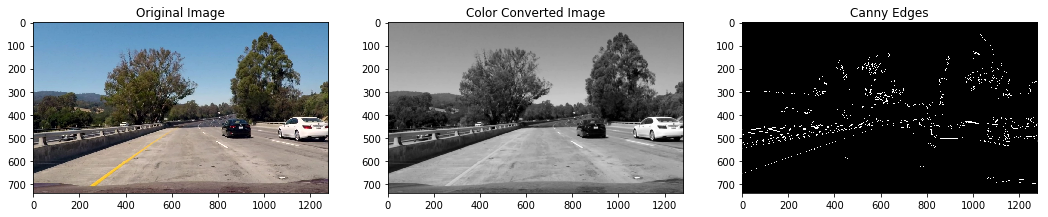

In [38]:
image = mpimg.imread('challenge/light.jpg')
image_gr = grayscale(image)
image_gr_blur = gaussian_blur(image_gr, 5)
edges = cv2.Canny(image_gr_blur,80,255)
# plot all the images and their histograms
images = [image, image_gr_blur,edges]
titles = ["Original Image","Color Converted Image","Canny Edges"]

fig, ax = plt.subplots(1,3, sharex='col',figsize=(18, 10))
ax[0].imshow(images[0])
ax[0].set_title(titles[0])

ax[1].imshow(images[1],'gray')
ax[1].set_title(titles[1])
ax[2].imshow(images[2],'gray')
ax[2].set_title(titles[2])
plt.show()

In [24]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY
    
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_yellow = cv2.inRange(image_hsv, light_yellow, dark_yellow)
    image_white = cv2.inRange(image_hsv, lower_white, upper_white)
    ret_image = image_white+image_yellow
    return ret_image

#def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
#    return cv2.addWeighted(cv2.cvtColor(grayscale(initial_img), cv2.COLOR_GRAY2RGB), α, img, β, γ)

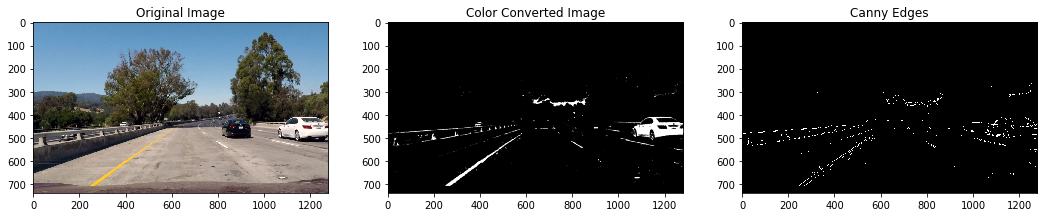

In [25]:
image = mpimg.imread('challenge/light.jpg')
image_gr = grayscale(image)
image_gr_blur = gaussian_blur(image_gr, 5)
edges = cv2.Canny(image_gr_blur,80,255)
# plot all the images and their histograms
images = [image, image_gr_blur,edges]
titles = ["Original Image","Color Converted Image","Canny Edges"]

fig, ax = plt.subplots(1,3, sharex='col',figsize=(18, 10))
ax[0].imshow(images[0])
ax[0].set_title(titles[0])
ax[1].imshow(images[1],'gray')
ax[1].set_title(titles[1])
ax[2].imshow(images[2],'gray')
ax[2].set_title(titles[2])
plt.show()



In [26]:
blur_kernel_size = 5
canny_low_threshold = 120
canny_high_threshold = 240
hough_rho = 2
hough_theta = np.pi/180
hough_threshold = 40
hough_min_line_len = 30
hough_max_line_gap = 10
challenge_output_3 = 'test_videos_output/challenge_3.mp4'

avg_ratio=0.2
frame_threshold = 15
initialize_avg_lines()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip5 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip5.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output_3, audio=False)
clip5.reader.close()
clip5.close()

Moviepy - Building video test_videos_output/challenge_3.mp4.
Moviepy - Writing video test_videos_output/challenge_3.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_3.mp4
Wall time: 25.2 s


<video width="640" height="360" controls src="test_videos_output/challenge_3.mp4" />